In [4]:
!pip install tensorboard==2.17.0

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

In [7]:
from datasets import load_dataset

dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 149
Test dataset size: 50


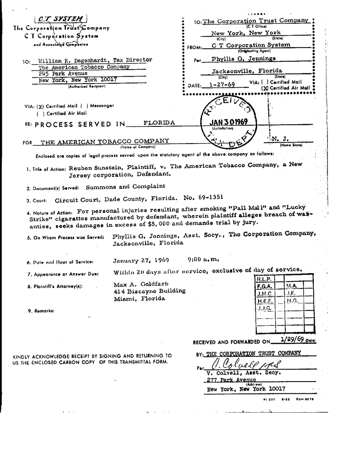

In [8]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][34]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

In [9]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [10]:
from transformers import LayoutLMv2Processor

# use LayoutLMv2 processor without ocr since the dataset already includes the ocr text
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])


dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


In [12]:
#Fine tuning is done here
from transformers import LayoutLMForTokenClassification

# huggingface hub model id
model_id = "microsoft/layoutlm-base-uncased"

# load model with correct number of labels and mapping
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])

In [14]:
!pip install --upgrade accelerate
import accelerate
print(accelerate.__version__)


^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
0.34.2


In [16]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# hugging face parameter
repository_id = "layoutlm-funsd"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=3e-5,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
# Starting the trainer
trainer.train()